# Guide for processing nuclei data extracted from cellpose algorithm

### Segmenting nuclei using cellpose algorithm

https://cellpose.readthedocs.io/en/latest/ - link to cellpose

we're going to start by generating the nuclear segmentations for two images in the *data/* path.

alternatively, you can run the following command in the top level directory from the command line:
> python -m cellpose --dir data/ --pretrained_model nuclei --diameter 0. --save_png

this will take about 20 minutes

In [1]:
import os

os.system("python -m cellpose --dir /Users/laila/Desktop/data/data1008/ --img_filter dapi_* --pretrained_model nuclei --diameter 0. --save_png")


0

Now that we out segmented data we want to load the segmentations.

In [8]:
# Import various libraries
import numpy as np
import time, os, sys
import matplotlib.pyplot as plt
import glob
from scipy import ndimage as ndi
from skimage import color, feature, filters, io, measure, morphology, restoration, segmentation, exposure, restoration, data
import warnings
import math
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from numpy import genfromtxt

input_path = '~/Desktop/data/' # changed to 'data/'

output_path = input_path  # change this as needed

sample = 'H2B2DE_p20200709_f20200715_20xHCR_002_cDAPI_z12' # name of sample
# the other sample is H2B2DE_p20200709_f20200715_20xHCR_002_cDAPI_z12

path_to_sample = '/Users/laila/Desktop/data/H2B2DE_p20200709_f20200715_20xHCR_002_cDAPI_z12_seg.npy'

newnp = np.asarray(np.load(path_to_sample, allow_pickle=True)).item() # this loads the segmentation as an array
outs = (newnp['outlines'] > 0).astype(int) # load the outlines around the nuclei
masks = newnp['masks'] # load the masks
imorig = newnp['img'] # load the original images

# initial column names for final output
column_names = ["near_contrast","near_dissim", "near_corr", "near_energy", "near_homog",
                "mid_contrast","mid_dissim", "mid_corr", "mid_energy", "mid_homog",
                "far_contrast","far_dissim", "far_corr", "far_energy", "far_homog",
                "puncta_count", "puncta_area"]

image_props = measure.regionprops_table(masks, intensity_image=imorig,properties=('label','area','filled_area',
                                                                                    'bbox', 'centroid',
                                                                                     'eccentricity','solidity','convex_area',
                                                                                     'mean_intensity','min_intensity','max_intensity',
                                                                                     'orientation','major_axis_length','minor_axis_length',
                                                                                     'perimeter','extent','intensity_image'))
im_df = pd.DataFrame(image_props)
otherfets = pd.DataFrame()

contrast_vec = np.empty((1,1))

for j in range(im_df.shape[0]):
        infoc = np.sum((im_df['intensity_image'][j]-np.mean(im_df['intensity_image'][j]))**2)
        contrast_vec = np.append(contrast_vec,infoc)

        imtest = im_df['intensity_image'][j].astype('uint8')
        minaxis = im_df['minor_axis_length'][j]

        gclm_farrange = greycomatrix(imtest, [minaxis/2], angles=[0], levels=256,
                                symmetric=False, normed=True)

        gclm_midrange = greycomatrix(imtest, [minaxis/4], angles=[0], levels=256,
                                symmetric=False, normed=True)

        gclm_closerange = greycomatrix(imtest, distances=[2], angles=[0], levels=256,
                                symmetric=False, normed=True)

        intimage = im_df['intensity_image'][j]
        spotlabels = measure.label(intimage, connectivity=2, background=0)

        npspots = np.max(np.unique(spotlabels))
        spotpixels = len(spotlabels[spotlabels!=0])


        tmpvals = [greycoprops(gclm_closerange, 'contrast')[0,0],
         greycoprops(gclm_closerange, 'dissimilarity')[0,0],
         greycoprops(gclm_closerange, 'correlation')[0,0],
         greycoprops(gclm_closerange, 'energy')[0,0],
         greycoprops(gclm_closerange, 'homogeneity')[0,0],
         greycoprops(gclm_midrange, 'contrast')[0,0],
         greycoprops(gclm_midrange, 'dissimilarity')[0,0],
         greycoprops(gclm_midrange, 'correlation')[0,0],
         greycoprops(gclm_midrange, 'energy')[0,0],
         greycoprops(gclm_midrange, 'homogeneity')[0,0],
         greycoprops(gclm_farrange, 'contrast')[0,0],
         greycoprops(gclm_farrange, 'dissimilarity')[0,0],
         greycoprops(gclm_farrange, 'correlation')[0,0],
         greycoprops(gclm_farrange, 'energy')[0,0],
         greycoprops(gclm_farrange, 'homogeneity')[0,0],
         npspots, spotpixels]

        erdf = pd.DataFrame(tmpvals).T

        otherfets = otherfets.append(erdf, ignore_index=True)


otherfets.columns = column_names
#    df_c = pd.concat([im_df.reset_index(drop=True), xs], axis=1)
df_c = pd.concat([im_df.reset_index(drop=True), otherfets], axis=1)
tmpdf = pd.DataFrame(contrast_vec[1:])
tmpdf.columns = ['imvar']

im2_df = pd.concat([df_c.reset_index(drop=True), tmpdf], axis=1)

print ("ran")

ran


Show an image of the fluorescent nuclei.

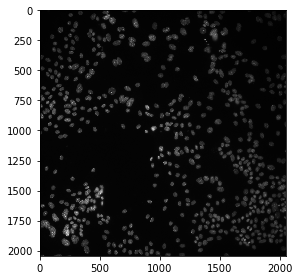

In [9]:
io.imshow(imorig)

Show an image of maks for the nuclei.

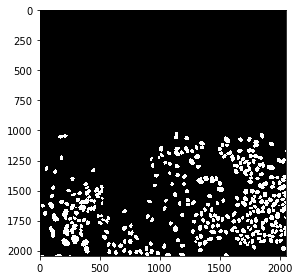

In [10]:
io.imshow(masks>=300)

Now, we are going to create a dataframe of the features. Python/scikit-image has built in functions that are capable of generating most of these features.

In [11]:
# initial column names for final output
column_names = ["near_contrast","near_dissim", "near_corr", "near_energy", "near_homog",
                "mid_contrast","mid_dissim", "mid_corr", "mid_energy", "mid_homog",
                "far_contrast","far_dissim", "far_corr", "far_energy", "far_homog",
                "puncta_count", "puncta_area"]

image_props = measure.regionprops_table(masks, intensity_image=imorig,properties=('label','area','filled_area',
                                                                                    'bbox', 'centroid',
                                                                                     'eccentricity','solidity','convex_area',
                                                                                     'mean_intensity','min_intensity','max_intensity',
                                                                                     'orientation','major_axis_length','minor_axis_length',
                                                                                     'perimeter','extent','intensity_image'))
im_df = pd.DataFrame(image_props)
otherfets = pd.DataFrame()
im_df = pd.DataFrame(image_props)
otherfets = pd.DataFrame()

contrast_vec = np.empty((1,1))



Some of the features are not automatically detected using the region properties. Below we go nucleus by nucleus to determine the contrast properties.

In [12]:
for j in range(im_df.shape[0]):
        infoc = np.sum((im_df['intensity_image'][j]-np.mean(im_df['intensity_image'][j]))**2)
        contrast_vec = np.append(contrast_vec,infoc)

        imtest = im_df['intensity_image'][j].astype('uint8')
        minaxis = im_df['minor_axis_length'][j]

        gclm_farrange = greycomatrix(imtest, [minaxis/2], angles=[0], levels=256,
                                symmetric=False, normed=True)

        gclm_midrange = greycomatrix(imtest, [minaxis/4], angles=[0], levels=256,
                                symmetric=False, normed=True)

        gclm_closerange = greycomatrix(imtest, distances=[2], angles=[0], levels=256,
                                symmetric=False, normed=True)

        intimage = im_df['intensity_image'][j]
        spotlabels = measure.label(intimage, connectivity=2, background=0)

        npspots = np.max(np.unique(spotlabels))
        spotpixels = len(spotlabels[spotlabels!=0])


        tmpvals = [greycoprops(gclm_closerange, 'contrast')[0,0],
         greycoprops(gclm_closerange, 'dissimilarity')[0,0],
         greycoprops(gclm_closerange, 'correlation')[0,0],
         greycoprops(gclm_closerange, 'energy')[0,0],
         greycoprops(gclm_closerange, 'homogeneity')[0,0],
         greycoprops(gclm_midrange, 'contrast')[0,0],
         greycoprops(gclm_midrange, 'dissimilarity')[0,0],
         greycoprops(gclm_midrange, 'correlation')[0,0],
         greycoprops(gclm_midrange, 'energy')[0,0],
         greycoprops(gclm_midrange, 'homogeneity')[0,0],
         greycoprops(gclm_farrange, 'contrast')[0,0],
         greycoprops(gclm_farrange, 'dissimilarity')[0,0],
         greycoprops(gclm_farrange, 'correlation')[0,0],
         greycoprops(gclm_farrange, 'energy')[0,0],
         greycoprops(gclm_farrange, 'homogeneity')[0,0],
         npspots, spotpixels]

        erdf = pd.DataFrame(tmpvals).T

        otherfets = otherfets.append(erdf, ignore_index=True)


Lastly, we concatenate the contrast dataframe to the original feature dataframe to get a more extensive dataframe. Print the dataframe.

In [13]:
otherfets.columns = column_names
#    df_c = pd.concat([im_df.reset_index(drop=True), xs], axis=1)
df_c = pd.concat([im_df.reset_index(drop=True), otherfets], axis=1)
tmpdf = pd.DataFrame(contrast_vec[1:])
tmpdf.columns = ['imvar']

im2_df = pd.concat([df_c.reset_index(drop=True), tmpdf], axis=1)

### prints several lines of the dataframe.
im2_df

,label,area,filled_area,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,eccentricity,...,mid_energy,mid_homog,far_contrast,far_dissim,far_corr,far_energy,far_homog,puncta_count,puncta_area,imvar
0,1,62,62,0,804,4,823,1,813,0.973038,...,0.157135,0.116021,12150.235294,87.117647,0.061371,0.131533,0.068589,62.0,62.0,2.013660e+09
1,2,127,127,0,1894,7,1917,2,1905,0.951336,...,0.150431,0.139745,9621.263158,76.631579,0.181159,0.107653,0.075066,126.0,127.0,3.642341e+08
2,3,218,218,0,54,10,82,3,67,0.920284,...,0.113561,0.104866,13298.295652,92.191304,0.049919,0.081108,0.058351,217.0,218.0,2.837174e+09
3,4,415,415,0,1726,16,1761,6,1743,0.870034,...,0.132083,0.135562,12321.122685,89.030093,0.087696,0.072020,0.057424,414.0,415.0,2.885721e+09
4,5,902,902,0,677,20,737,7,707,0.939104,...,0.156216,0.165825,12373.221000,86.951000,0.144845,0.101025,0.104310,898.0,902.0,2.943191e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,629,806,806,2020,1531,2044,1575,2033,1550,0.824732,...,0.109044,0.114684,13924.501302,95.631510,-0.002296,0.062986,0.060608,803.0,806.0,1.078671e+10
629,630,704,704,2029,117,2044,181,2037,152,0.971013,...,0.202308,0.209885,11273.732143,79.898810,0.185091,0.159426,0.165699,702.0,704.0,2.875400e+10
630,631,290,290,2034,0,2044,36,2039,16,0.956215,...,0.123909,0.128831,12239.354839,85.987097,0.119504,0.090323,0.087220,290.0,290.0,6.716483e+09
631,632,95,95,2039,238,2044,262,2041,249,0.975877,...,0.178420,0.177708,15870.723810,100.952381,-0.013794,0.126706,0.102045,95.0,95.0,2.348580e+09


Last we export the dataframe. Repeat this for the other image

In [14]:
export = im2_df.to_csv(output_path + sample + ".improps.csv", index = None, header=True)
